Você pode rodar este notebook localmente ou no Colab. Para abrir diretamente no Colab, basta clicar no botão abaixo.

[![Open In Colab](https://colab.research.google.com/assets/colab-badge.svg)](https://colab.research.google.com/github/pablo-sampaio/rl_facil/blob/main/cap02/cap02-main.ipynb) 

# Capítulo 2 - Bandidos Multibraços (Multi-Armed Bandits)

Neste notebook, apresentamos resultados de testes (mais simples e mais elaborados) envolvendo os principais algoritmos para este problema. 

Para melhor entender os algoritmos, é recomendado acessar os scripts da pasta "cap02", onde os códigos foram definidos.

## Configurações Iniciais

Para instalar e importar pacotes e configurar algumas coisas...

In [ ]:
from IPython.display import clear_output
import sys

if 'google.colab' in sys.modules:
    # clone repository, to use "util" module 
    !git clone https://github.com/pablo-sampaio/rl_facil
    sys.path.append("/content/rl_facil")
    clear_output()
else:
    from os import path
    sys.path.append( path.dirname( path.dirname( path.abspath("__main__") ) ) )

In [ ]:
from util.bandit_envs import MultiArmedBanditEnv, GaussianMultiArmedBanditEnv
from util.experiments import repeated_exec
from util.plot import plot_multiple_results

## 1 - Testando os ambientes

Existem dois ambientes, no modulo **`util.bandit_envs`**. Ambos recebem uma ação representada como um número inteiro a partir de 0 e retorna uma recompensa numérica `float`.
- **MultiArmedBanditEnv**: Retorna recompensas 0 ou 1, de acordo com a ação. Cada ação tem uma probabilidade, passada no construtor (e desconhecida dos algoritmos).
- **GaussianMultiArmedBanditEnv**: retorna recompensas com distribuição normal (gaussiana), cujos valores são contínuos e ocorrem com maior probabilidade perto da média (mas podem ir de `-inf` a `+inf`). Cada ação tem uma média passada no construtor (e desconhecida dos algoritmos).

Em cada ambiente, vamos testar aplicar a sequência de ações abaixo, que apenas alterna ação **0** e ação **1**.

In [ ]:
STEPS = 12
actions = [ 0, 1 ] * (STEPS//2)
actions

In [ ]:
env1 = MultiArmedBanditEnv()

env1.reset()
for i in range(STEPS):
    a = actions[i]
    r = env1.step(a)
    print(" - ação", a, ", recompensa", r)

In [ ]:
env2 = GaussianMultiArmedBanditEnv()

env2.reset()
for i in range(STEPS):
    a = actions[i]
    r = env2.step(a)
    print(" - ação", a, ", recompensa", r)

## 2 - Soluções Baseline


In [ ]:
from cap02.baseline_algorithms import run_greedy, run_random

Abaixo, vamos testar duas soluções simples usadas como base para comparação (ou seja, soluções de *baseline*):
- **greedy**: depois de fazer 1 vez cada ação, escolhe a melhor e repete para sempre
- **random**: escolher qualquer ação aleatoriamente

Vamos apresentar testes no ambiente abaixo, com três ações de probabilidades 20%, 50% e 75% de retornar recompensa 1.



In [ ]:
BANDIT_PROBABILITIES = [0.2, 0.5, 0.75]
env = MultiArmedBanditEnv(BANDIT_PROBABILITIES)

***Qual dos dois algoritmos você acha que vai se sair melhor?***

Abaixo, testamos os dois algoritmos rodando por 10 mil passos. Execute mais de uma vez a célula e veja como o resultado varia.

In [ ]:
rewards, _ = run_greedy(env, total_steps=10000)
print("Greedy - soma de recompensas:", sum(rewards))

rewards, _ = run_random(env, total_steps=10000)
print("Random - soma de recompensas:", sum(rewards))

Depois de fazer alguns testes, você deve perceber que um deles varia muito nos resultados. A seguir, vamos fazer experimentos executando ambos várias vezes e plotamos a recompensa média recebida até cada passo. 

In [ ]:
RUNS  = 50
STEPS = 10000

result_random = repeated_exec(RUNS, "RANDOM", run_random, env, STEPS)
result_greedy = repeated_exec(RUNS, "GREEDY", run_greedy, env, STEPS)
result_random

In [ ]:
for (alg_name, rewards) in [result_greedy, result_random]:
    print()
    print("Summary for " + alg_name)
    print(" - total reward:", rewards.sum())
    print(" - avg reward (win rate):", rewards.sum() / STEPS)

In [ ]:
plot_multiple_results([result_greedy, result_random], cumulative=True, x_log_scale=True, yreference=env.get_max_mean_reward())

O resultado acima deve mostrar resultados próximos, no longo prazo. Na verdade, se for executado por tempo suficiente, eles tendem a ficar iguais. Porém, um deles apresenta maior variação. 

Nos gráficos abaixo, mostramos o gráfico individualizado para cada algoritmo, junto com uma área sombreada que mostra 1 desvio padrão da média para cima e para baixo. Assim, a área sombreada dá uma ideia de quanto variam os resultados entre as várias execuções (indicada por `RUNS`).

In [ ]:
plot_multiple_results([result_greedy], cumulative=True, x_log_scale=True, yreference=env.get_max_mean_reward(), plot_stddev=True)

In [ ]:
plot_multiple_results([result_random], cumulative=True, x_log_scale=True, yreference=env.get_max_mean_reward(), plot_stddev=True)

## 3 - Epsilon-Greedy

In [ ]:
from cap02.epsilon_greedy import run_epsilon_greedy

Nesta solução, um parâmetro **`epsilon`** controla o grau de exploração (*exploration*) do algoritmo, que escolhe ações assim:
- com probabilidade *epsilon*: faz uma ação qualquer
- com probabilidade *(1.0-epsilon)*: faz a ação de melhor média (até o momento)

Vamos fazer alguns experimentos, com diferentes valores de *epsilon*.

In [ ]:
BANDIT_PROBABILITIES = [0.2, 0.5, 0.75]
env = MultiArmedBanditEnv(BANDIT_PROBABILITIES)

rewards, _ = run_epsilon_greedy(env, total_steps=10000, epsilon=0.2)
print(f"Eps-greedy (0.2) - soma de recompensas:", sum(rewards))

rewards, _ = run_epsilon_greedy(env, total_steps=10000, epsilon=0.1)
print(f"Eps-greedy (0.1) - soma de recompensas:", sum(rewards))

rewards, _ = run_epsilon_greedy(env, total_steps=10000, epsilon=0.01)
print(f"Eps-greedy (0.01) - soma de recompensas:", sum(rewards))

A seguir, vamos comparações entre duas versões do *epsilon-greedy* e o *random*.

In [ ]:
RUNS  = 50
STEPS = 10000

results = []
results.append( repeated_exec(RUNS, "RANDOM", run_random, env, STEPS) )

for epsilon in [0.02, 0.10, 0.30]:
    results.append( repeated_exec(RUNS, f"EPS({epsilon})-GREEDY", run_epsilon_greedy, env, STEPS, epsilon) )

for (alg_name, rewards) in results:
    print()
    print("Summary for " + alg_name)
    print(" - total reward:", rewards.sum())
    print(" - avg reward (win rate):", rewards.sum() / STEPS)

In [ ]:
plot_multiple_results(results, cumulative=True, x_log_scale=True, yreference=env.get_max_mean_reward())

In [ ]:
plot_multiple_results(results, cumulative=True, x_log_scale=True, yreference=env.get_max_mean_reward(), plot_stddev=True)

Uma deficiência do **epsilon-greedy** padrão é que ele *sempre* vai explorar, e sempre na mesma proporção (dada pelo *epsilon*).

Uma solução melhor consiste em fazer o epsilon diminuir com o tempo. 




## 4 - Decaying Epsilon-Greedy

Nesta variante, o epsilon decai ao longo do tempo. Não daremos a implementação pronta do **decaying epsilon-greedy**. Mas, aqui, discutimos como fazer o decaimento do valor do epsilon.

Uma ideia para o decaimento é fazer o valor de epsilon se comportar assim:
- inicia com um valor inicial *`initial_epsilon`*, que pode ser sempre 1.0 (100% de exploração)
- cai até um valor mínimo dado pelo parâmetro *`minimum_epsilon`*
- esse valor mínimo é atingido no passo dado pelo parâmetro *`target_step`*

Esse decaimento pode ser feito de forma *linear* ou *exponencial* (mas existem outros). Abaixo, mostramos como o valor do epsilon varia nos dois esquemas citados para `minimun_epsilon=0.01` e `target_step=7000`. 

In [ ]:
import matplotlib.pyplot as plt
from cap02.decaying_schemes import exponential_decay, linear_decay

mininimu_epsilon = 0.01
target_step = 7000
step_sequence = range(1, 10000 + 1)

for label, decay_scheme in [("exponential", exponential_decay), ("linear", linear_decay)]:
    get_epsilon_fn = decay_scheme(mininimu_epsilon, target_step)
    plt.plot(step_sequence, [get_epsilon_fn(t) for t in step_sequence], label=label)

plt.legend()


Note que tanto `exponential_decay()` como `linear_decay()` retornam funções. A função retornada recebe o passo atual e retorna o valor correspondente desejado (para *epsilon*). Veja o arquivo `decaying_schemes.py` para entender melhor.

Agora é com você: implemente o **decaying epsilon-greedy** simplesmente integrando alguma dessas formas de decaimento (ou ambas) ao código do epsilon-greedy.

In [ ]:
# faça aqui
def run_decaying_epsilon_greedy():
  pass


## 5 - UCB

In [ ]:
from cap02.ucb import run_ucb

O **UCB** usa uma única fórmula para avaliar cada possível ação. Essa fórmula engloba o **Q** da ação (como termo de "exploitação") e um termo que mede a incerteza da ação (como fator de exploração). A incerteza é alta para ações escolhidas "poucas" vezes. O UCB escolhe sempre a ação que dê a melhor soma desses termos. 

Um parâmetro **c** controla a contribuição do termo de incerteza. O valor padrão é `2.0`. 

In [ ]:
BANDIT_PROBABILITIES = [0.2, 0.5, 0.75]
env = MultiArmedBanditEnv(BANDIT_PROBABILITIES)

rewards, _ = run_ucb(env, 10000, c=2.0)
print(f"UCB(c=2.0) - soma de recompensas:", sum(rewards))

rewards, _ = run_ucb(env, 10000, c=1.0)
print(f"UCB(c=1.0) - soma de recompensas:", sum(rewards))

rewards, _ = run_ucb(env, 10000, c=0.5)
print(f"UCB(c=0.5) - soma de recompensas:", sum(rewards))

rewards, _ = run_random(env, total_steps=10000)
print("Random - soma de recompensas:", sum(rewards))

In [ ]:
RUNS  = 50
STEPS = 10000

results = []
results.append( repeated_exec(RUNS, "RANDOM", run_random, env, STEPS) )

for param_c in [0.5, 1.0, 2.0]:
  results.append( repeated_exec(RUNS, f"UCB(c={param_c})", run_ucb, env, STEPS, param_c) )

plot_multiple_results(results, cumulative=True, x_log_scale=True, yreference=env.get_max_mean_reward())
#plot_multiple_results(results, cumulative=True, x_log_scale=True, yreference=env.get_max_mean_reward(), plot_stddev=True)

In [ ]:
plot_multiple_results(results[1:2], cumulative=True, x_log_scale=True, yreference=env.get_max_mean_reward(), plot_stddev=True)

Vemos nos resultados valores menores de *c* tiverem melhor desempenho.

## 6 - Comparação Geral

Vamos fazer experimentos comparando:
- **random** para servir de comparação, como solução "ruim"
- **epsilon-greedy** com o melhor valor de *epsilon* encontramos antes
- **ucb** com o melhor valor de *c* que encontramos

Vamos rodar (reiniciando) cada algoritmo 70 vezes. Cada execução terá 14 mil passos. Vamos fazer experimentos separados para as duas versões de ambiente.

In [ ]:
# parâmetros dos algoritmos
epsilon = 0.02
param_c = 0.5

# parâmetros que controlam a repetição e duração dos experimentos
RUNS  = 70
STEPS = 140000

# esta variável é para carregar automaticamente resultados de simulações já executadas
auto_load = True

### 6.1 - Com Multi-Armed Bandit de recompensas binárias

Aqui, usamos o ambiente padrão, com probabilidades bem próximas, para tentar "confundir" os algoritmos no início de cada execução.

In [ ]:
BANDIT_PROBABILITIES = [0.4, 0.5, 0.55]
env = MultiArmedBanditEnv(BANDIT_PROBABILITIES)

In [ ]:
results = []

results.append( repeated_exec(RUNS, "RANDOM", run_random, env, STEPS, auto_load=auto_load) )
results.append( repeated_exec(RUNS, f"EPS({epsilon})-GREEDY", run_epsilon_greedy, env, STEPS, epsilon, auto_load=auto_load) )
results.append( repeated_exec(RUNS, f"UCB(c={param_c})", run_ucb, env, STEPS, param_c, auto_load=auto_load) )

plot_multiple_results(results, cumulative=True, x_log_scale=True, yreference=env.get_max_mean_reward())

In [ ]:
plot_multiple_results(results, cumulative=True, x_log_scale=True, yreference=env.get_max_mean_reward(), plot_stddev=True)

### 6.2 - Com Multi-Armed Bandit de recompensas gaussianas

Aqui, usamos o ambiente com recompensas gaussianas (distribuição normal), com médias bem próximas, para tentar "confundir" os algoritmos no início. 

In [ ]:
BANDIT_MEANS = [0.4, 0.5, 0.55]
env_gauss = GaussianMultiArmedBanditEnv(BANDIT_MEANS)

In [ ]:
results_gauss = []

results_gauss.append( repeated_exec(RUNS, "RANDOM", run_random, env_gauss, STEPS, auto_load=auto_load) )
results_gauss.append( repeated_exec(RUNS, f"EPS({epsilon})-GREEDY", run_epsilon_greedy, env_gauss, STEPS, epsilon, auto_load=auto_load) )
results_gauss.append( repeated_exec(RUNS, f"UCB(c={param_c})", run_ucb, env_gauss, STEPS, param_c, auto_load=auto_load) )

plot_multiple_results(results_gauss, cumulative=True, x_log_scale=True, yreference=env.get_max_mean_reward())

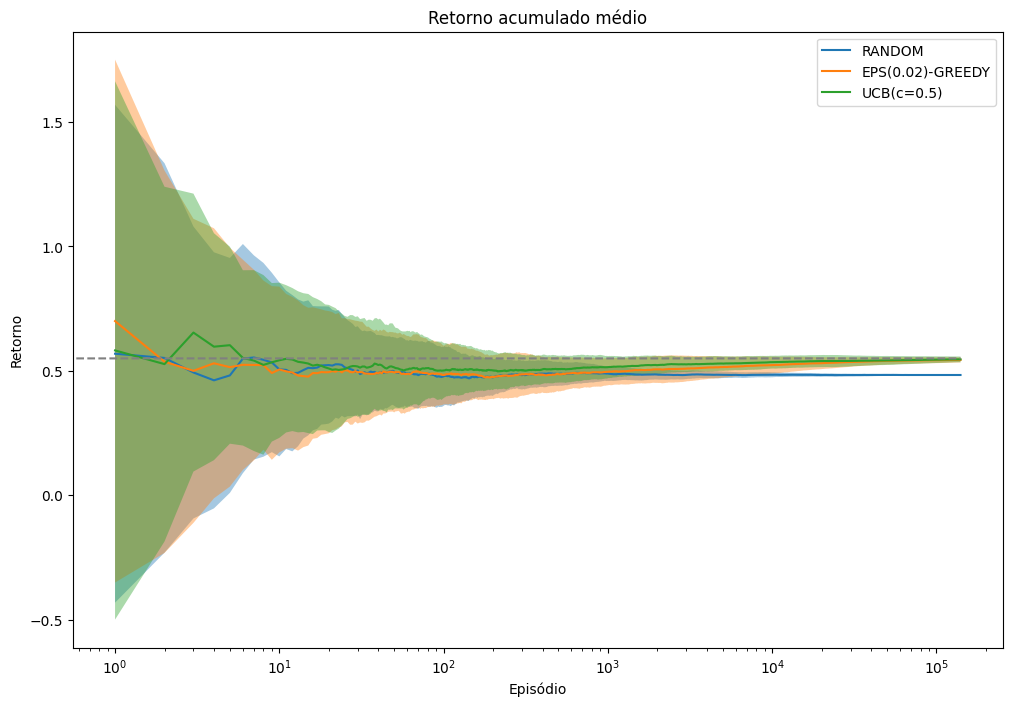

In [49]:
plot_multiple_results(results_gauss, cumulative=True, x_log_scale=True, yreference=env.get_max_mean_reward(), plot_stddev=True)